In [1]:
import sqlite3

import numpy as np
import pandas as pd

Reading the raw dataset.

In [2]:
connection = sqlite3.connect("../raw/commoncrawl_news_articles/articles.db")

df = pd.read_sql("SELECT content_preprocessed, au.outlet_name FROM article_contents ac INNER JOIN article_urls au on ac.uuid = au.uuid WHERE language = 'en'", connection)

outlets_df = pd.read_json(open("../raw/commoncrawl_news_articles/outlets.json"))
df = df.merge(outlets_df, how="outer", left_on="outlet_name", right_on="name")
df

,content_preprocessed,outlet_name,name,tld,filter,allsides_rating,allsides_name
0,Ukraine's president is pleading with citizens ...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
1,"Youtube\n“It’s a phenomenon, but so is the Her...",ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
2,Rep. Liz Cheney leaves House chamber with her ...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
3,"Will Smith, Lady Gaga and Ben Affleck landed i...",ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
4,Taiwan says 27 Chinese aircraft entered its ai...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
...,...,...,...,...,...,...,...
520799,"""I’m quite concerned,"" warned Goldman's Abby J...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520800,A recent report by the Middle East Media Resea...,ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520801,"It's that time again when Jeffrey Gundlach, th...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520802,"As we discussed yesterday, when looking at the...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge


Dropping useless columns.

In [3]:
df = df.drop(columns=["outlet_name", "name", "tld", "filter", "allsides_name"])

Renaming columns.

In [4]:
df = df.rename(columns={"content_preprocessed": "body", "allsides_rating": "leaning"})

Categorizing the leaning column.

In [5]:
df["leaning"].unique()

array(['lean left', 'center', 'right', 'left', 'lean right'], dtype=object)

In [6]:
df["leaning"] = df["leaning"].replace({"lean left": "left", "lean right": "right"})
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [7]:
df = df.dropna()

Printing duplicates.

In [8]:
df[df["body"].duplicated(keep=False)]

,body,leaning
3,"Will Smith, Lady Gaga and Ben Affleck landed i...",left
20,Interest Successfully Added\nWe'll notify you ...,left
22,Interest Successfully Added\nWe'll notify you ...,left
23,Interest Successfully Added\nWe'll notify you ...,left
25,Nissan Concept 2020 Vision Gran Turismo Nissan...,left
...,...,...
519702,Featured Photo Galleries\nGreatest gun-toting ...,right
519706,"** For in-depth results, click a county above....",right
519726,Featured Photo Galleries\nGreatest gun-toting ...,right
519729,Featured Photo Galleries\nGreatest gun-toting ...,right


Dropping the duplicates.

In [9]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [10]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df.sort_values(by="body_length", ascending=False).head()

,body,leaning,body_length,body_word_count
308036,Keith plays in a rock & roll band.<SENT_END>An...,left,115613,17742
259915,Editor’s Note: This is the fourth collection o...,right,111770,16049
318293,"""This is my maiden voyage.<SENT_END>My first s...",left,109986,16397
300847,Some of us have spent nearly as much time in S...,left,109928,16389
64377,31 .<SENT_END>People rewarded by capitalism ne...,center,109650,17028


In [11]:
df.sort_values(by="body_length").head()

,body,leaning,body_length,body_word_count
341484,"“I know it was your idea, but it was my idea t...",left,63,15
24119,"""We would only do it if it was a challenge, bu...",center,65,15
356401,“I don’t tell you how to do your job—don’t tel...,left,67,15
351781,"“I’ll go to my room and do my homework, but I ...",left,68,16
346719,“Keep in mind that by the day of the wedding I...,left,69,15


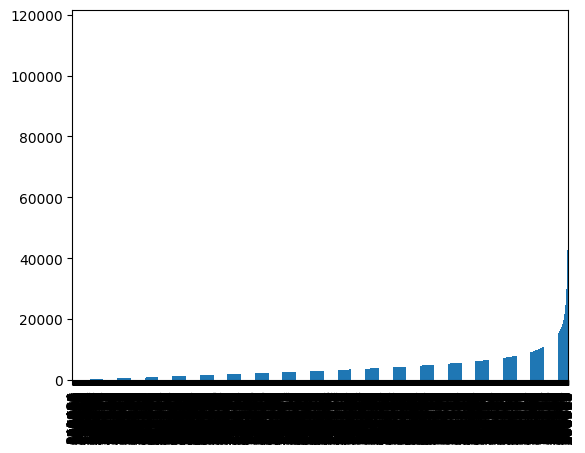

In [12]:
body_length = df["body_length"].sort_values()
# Ensuring to include the last (longest) item.
downsampled = pd.concat([body_length.iloc[::100], body_length.iloc[[-1]]]).drop_duplicates()
downsampled.plot.bar();

Calculating the bounds for body length.

In [13]:
q1 = np.percentile(df["body_length"], 25)
q3 = np.percentile(df["body_length"], 75)
iqr = q3 - q1
lower_bound_multiplier = 0.5
upper_bound_multiplier = 9
lower_bound = q1 - lower_bound_multiplier * iqr
upper_bound = q3 + upper_bound_multiplier * iqr
lower_bound, upper_bound

(np.float64(-594.5), np.float64(39841.0))

Removing the outliers based on the body length.

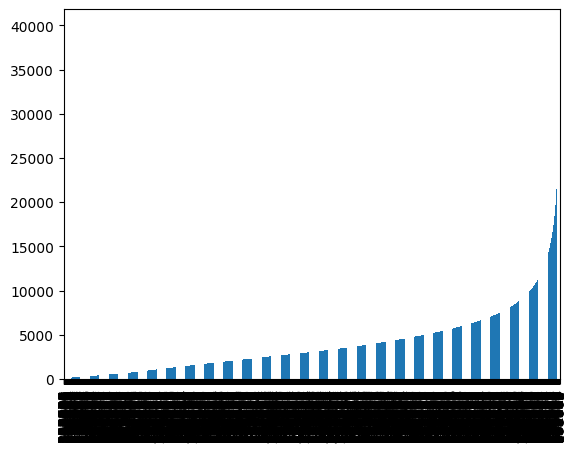

In [14]:
df = df[(df["body_length"] >= lower_bound) & (df["body_length"] <= upper_bound)]
body_length = df["body_length"].sort_values()
# Ensuring to include the last (longest) item.
downsampled = pd.concat([body_length.iloc[::100], body_length.iloc[[-1]]]).drop_duplicates()
downsampled.plot.bar();

The leaning distribution.

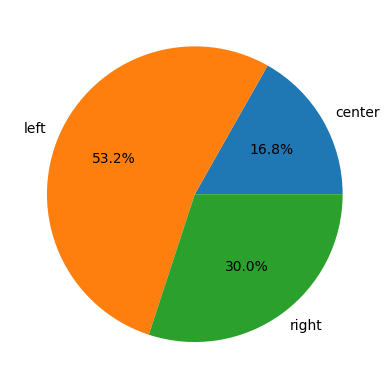

In [15]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

In [16]:
df.to_csv("../preprocessed/commoncrawl_news_articles.csv")